<a href="https://colab.research.google.com/github/buessow/glumagic/blob/master/modelling/Glucose_Prediction_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Imports
%load_ext google.colab.data_table

import datetime as datetime
import json
import os
import hashlib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime as datetime
import dateutil.parser
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as lines
from matplotlib.patches import Rectangle
import matplotlib.table as tab
import math
import numpy as np
import pandas as pd
import pytz
import pprint
import statistics
import sys
import unittest
import subprocess
from datetime import datetime
from datetime import time
from datetime import timedelta
from datetime import timezone
from google.colab import data_table
from google.colab import drive
from google.colab import output as co_out
# from google.colab import userdata
from IPython.display import Javascript

#mpl.style.use('dark_background')
data_table._DEFAULT_FORMATTERS[float] = lambda x: f'{x:.2f}'
data_table._DEFAULT_FORMATTERS[np.float32] = lambda x: f'{x:.2f}'

local_colab = 'COLAB_RELEASE_TAG' not in os.environ.keys()
CACHE_DIR = os.path.join(os.environ['HOME'], 'Google Drive', 'My Drive', 'Glucose Prediction Work')
if not os.path.exists(CACHE_DIR):
  local_colab = False
  CACHE_DIR = '/content/drive/My Drive/Glucose Prediction Work'

print(CACHE_DIR)

/Users/robertbuessow/Google Drive/My Drive/Glucose Prediction Work


In [2]:
#@title Import Library from Github
![ -d gmagic ] || git clone https://github.com/buessow/gmagic.git
!cd gmagic; git pull origin
from gmagic.lib import LogNormAction as lna
from gmagic.lib.DateTimeInsulin import DateTimeInsulin, TimeInsulin
from gmagic.lib.Profile import Profile
from gmagic.lib.ProfileSwitch import ProfileSwitch
from gmagic.lib.TempBasal import TempBasal

Already up to date.


In [3]:
![[ $local_colab == False ]] && apt-get install openjdk-17-jre-headless -qq > /dev/null
if not local_colab: os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
![[ $local_colab == False ]] && update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
!java -version

java version "17.0.7" 2023-04-18 LTS
Java(TM) SE Runtime Environment (build 17.0.7+8-LTS-224)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.7+8-LTS-224, mixed mode, sharing)


In [4]:
#@title Model Class
class M(object):
  def __init__(self, name, **kwargs):
    self.name = name
    self.test_data = []
    self.use_conv = False
    for k, v in kwargs.items():
      setattr(self, k, v)
    self.prev_error = {}
m = M('default')

In [5]:
#@title Model Data

M.START = '2020-01-01'
M.END = '2024-01-31'
M.VALIDATION = '2023-10-01'

M.FREQ_MINUTES = 5
M.FREQ = timedelta(minutes=M.FREQ_MINUTES)

M.TRAIN_MINUTES = 180
M.PRED_MINUTES = 60
M.PERIOD_T = timedelta(minutes=M.TRAIN_MINUTES)
M.PERIOD_P = timedelta(minutes=M.PRED_MINUTES)
M.PERIOD = M.PERIOD_T + M.PERIOD_P

M.PERIOD_X_MINUTES = list(range(0, M.TRAIN_MINUTES, M.FREQ_MINUTES))
M.PERIOD_Y_MINUTES = list(range(M.TRAIN_MINUTES, M.TRAIN_MINUTES + M.PRED_MINUTES, M.FREQ_MINUTES))
M.PERIOD_MINUTES = M.PERIOD_X_MINUTES + M.PERIOD_Y_MINUTES

M.HR_HIGH_THRESHOLD = 120
M.HR_LONG_MINUTES = [24 * 60, 48 * 60]
M.HR_LONG_COLS = ['hr_long', 'hr_lon2']

@property
def start_ts(self):
  return pd.to_datetime(self.START).tz_localize('UTC')
M.start_ts = start_ts
del start_ts

@property
def validation_start(self):
  return pd.to_datetime(self.VALIDATION).tz_localize('UTC')
M.validation_start = validation_start
del validation_start

history = pd.DataFrame()
history_file = os.path.join(CACHE_DIR, 'run_history.csv')
if os.path.exists(history_file):
  history = pd.read_csv(history_file)

m.validation_start

Timestamp('2023-10-01 00:00:00+0000', tz='UTC')

mode 0.500000
mode 0.750000


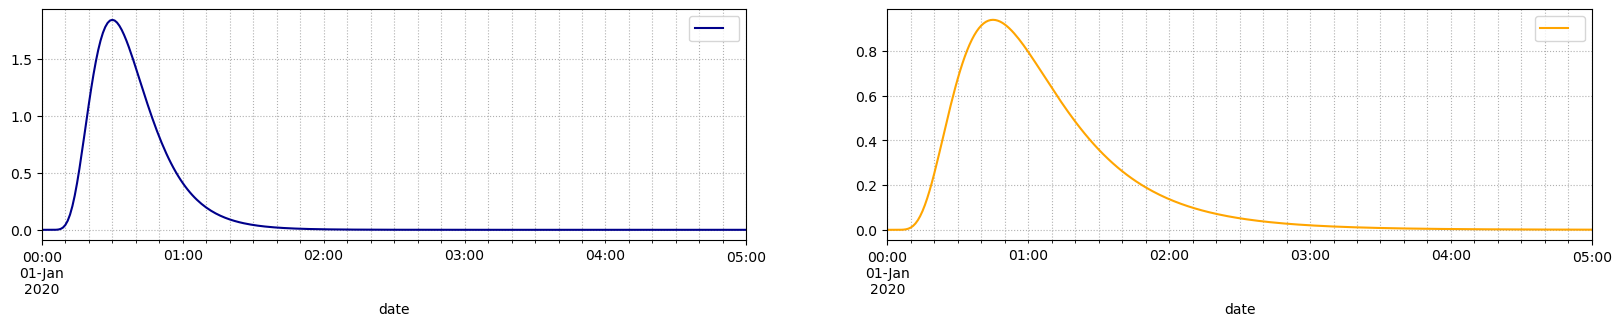

In [6]:
#@title Insulin and Carbohydrate Action
insulin_color = 'darkblue'
carb_color = 'orange'

M.INSULIN_ACTION = lna.LogNormAction(mode=timedelta(minutes=30), sigma=0.4)
M.CARB_ACTION = lna.LogNormAction(mode=timedelta(minutes=45), sigma=0.50)

_, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={}, figsize=(20,3))
M.INSULIN_ACTION.plot(timedelta(hours=5), color=insulin_color, ax=axs[0])
M.CARB_ACTION.plot(timedelta(hours=5), color=carb_color, ax=axs[1])

# print('mean %f' % M.INSULIN_ACTION.mean)

# Data Loading

In [7]:
def write_meta_json(self, file_name):
  meta = {
      'tensorflow_version': tf.__version__,
      'trainingPeriodMinutes': self.TRAIN_MINUTES,
      'predictionPeriodMinutes': self.PRED_MINUTES,
      'carbAction': {'mu': self.CARB_ACTION.mu, 'sigma': self.CARB_ACTION.sigma },
      'insulinAction': {'mu': self.INSULIN_ACTION.mu, 'sigma': self.INSULIN_ACTION.sigma },
      'hrHighThreshold': self.HR_HIGH_THRESHOLD,
      'hrLongDurationMinutes': self.HR_LONG_MINUTES,
      'testData': self.test_data,
      'freqMinutes': self.FREQ_MINUTES,
      'zoneId': 'CET',
  }
  with open(file_name, 'w') as f:
    json.dump(meta, f, indent=2)
  return meta
M.write_meta_json = write_meta_json
del write_meta_json

In [8]:
#@title Load Data

def load_data(self):
  meta_fname = '%s_load_meta.json' % self.name
  meta =  self.write_meta_json(meta_fname)
  meta['testData'] = None
  hash = hashlib.sha1(str(meta).encode()).hexdigest()
  fname = 'input_%s_%s_%s.csv' % (self.START, self.END, hash)
  if not os.path.exists(fname):
    print('loading "%s"' % fname)
    db = 'heroku_wxt9ng46'
    p = subprocess.run(args=[
        'java',
        '-jar', os.path.join(CACHE_DIR, 'glumagic-1.0.jar'),
        'api',
        '--configFile', meta_fname,
        '-from', self.START,
        '-to', self.END,
        '-db', db,
        '-k', 'l2G9aXCVJkqPI2uHDGJFdMSK1oM6x4chEZ9Ef3DEkz4fByczGqa6FCmMNaIVPblG', #userdata.get('mongoApiKey'),
        '-o', fname],
        capture_output=True, encoding='UTF-8',
        env={'JAVA_HOME': '/usr/lib/jvm/java-17-openjdk-amd64'})
    print('loading result %d %s' % (p.returncode, p.stderr))

  self.glucose = pd.read_csv(fname)
  self.glucose.date = pd.to_datetime(self.glucose.date)
  self.glucose.set_index('date', inplace=True)
  self.glucose.rename({
    'glucoseSlope1': 'gl_slope',
    'glucoseSlope2': 'gl_slop2',
    'hrLong1': 'hr_long',
    'hrLong2': 'hr_lon2',
    'heartRate': 'hr',
    'carbAction': 'ca',
    'insulinAction': 'ia'}, axis=1, errors='raise', inplace=True)
  self.glucose.glucose.where(self.glucose.glucose > 20.0, inplace=True)
  self.glucose.glucose.ffill(limit=6, inplace=True)
  self.glucose.hr.ffill(limit=3, inplace=True)
  self.glucose.hr.fillna(value=60.0, inplace=True)
  self.glucose.dropna(inplace=True, subset=['glucose'])

  print('load data from %s, shape=%s' % (fname, str(self.glucose.shape)))

M.load_data = load_data
m.load_data()
m.glucose[['glucose', 'hr', 'carbs', 'ca', 'bolus', 'basal', 'ia']][410000:][:10000]

loading "input_2020-01-01_2024-01-31_78200080734d720414612f0b4c8c6f24babf5b44.csv"
loading result 0 
load data from input_2020-01-01_2024-01-31_78200080734d720414612f0b4c8c6f24babf5b44.csv, shape=(419200, 12)


glucose    hr  carbs  ...  bolus     basal        ia
date                                                ...                           
2023-12-30 00:00:00+00:00   99.508360  56.0    0.0  ...    0.0  0.105625  0.643184
2023-12-30 00:05:00+00:00  101.254180  55.8    0.0  ...    0.0  0.105625  0.599639
2023-12-30 00:10:00+00:00  101.745820  55.2    0.0  ...    0.0  0.029404  0.567235
2023-12-30 00:15:00+00:00  100.237460  55.8    0.0  ...    0.0  0.022658  0.553849
2023-12-30 00:20:00+00:00   99.270905  55.0    0.0  ...    0.0  0.006578  0.563904
...                               ...   ...    ...  ...    ...       ...       ...
2024-01-30 23:35:00+00:00  106.000000  48.0    0.0  ...    0.0  0.000000  1.803043
2024-01-30 23:40:00+00:00   97.766670  48.0   20.0  ...    0.0  0.005522  1.789655
2024-01-30 23:45:00+00:00   68.000000  48.0    0.0  ...    0.0  0.000000  1.744762
2024-01-30 23:50:00+00:00   68.000000  48.0    0.0  ...    0.0  0.000000  1.674596
2024-01-30 23:55:00+00:00   68.000000  48.0    0.0  ...    0.0  0.000000  1.585912

[9200 rows x 7 columns]

In [46]:
m.glucose.describe()

hour        glucose  ...             ia        gl_pred
count  419200.000000  419200.000000  ...  419200.000000  410400.000000
mean       11.505012     121.403075  ...       2.126012     119.201428
std         6.905632      41.651543  ...       1.871628      37.754685
min         0.000000      27.604563  ...       0.003659    -128.165546
25%         6.000000      92.474915  ...       0.869209      93.343369
50%        12.000000     113.000000  ...       1.470110     112.257124
75%        17.000000     143.069880  ...       2.747129     139.208277
max        23.000000     401.000000  ...      23.271513     416.477789

[8 rows x 13 columns]

In [9]:
#@title Slope Series
def slope_series(x_series, y_series, x_per=1):
  x_diff = x_series.shift(-1) - x_series
  y_diff = y_series.shift(-1) - y_series
  return x_diff / (y_diff / x_per)

In [10]:
from scipy.signal import savgol_filter
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxWidth: 5000})'''))

# display(Javascript('''google.colab.output.setIframeWidth(0, true, {width: 5000})'''))

class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    callback_id = 'button-10sasdf'
    co_out.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

def do_something():
  print('here')


def smooth_glucose(df):
  df = df.copy()
  # df.glucose = df.glucose.rolling(window=timedelta(minutes=15), center=True).mean()
  df.glucose = savgol_filter(df.glucose, window_length=7, polyorder=2)
  df.gl_slope = slope_series(df.glucose, df.index.to_series(), timedelta(minutes=1))
  df.gl_slop2 = slope_series(df.gl_slope, df.index.to_series(), timedelta(minutes=1))
  return df

# plt.subplots(figsize=(100, 6))
# s = pd.to_datetime('2020-01-02')
# xlim = (s, s + timedelta(days=7))
# ylim = (0, 200)
# df = smooth_glucose(m.glucose)
# df.glucose.plot(xlim=xlim, ylim=ylim, color='red', alpha=0.5, linewidth=3)
# m.glucose.glucose.plot(xlim=xlim, ylim=ylim, alpha=0.8)

InvokeButton('click me', do_something)

<IPython.core.display.Javascript object>

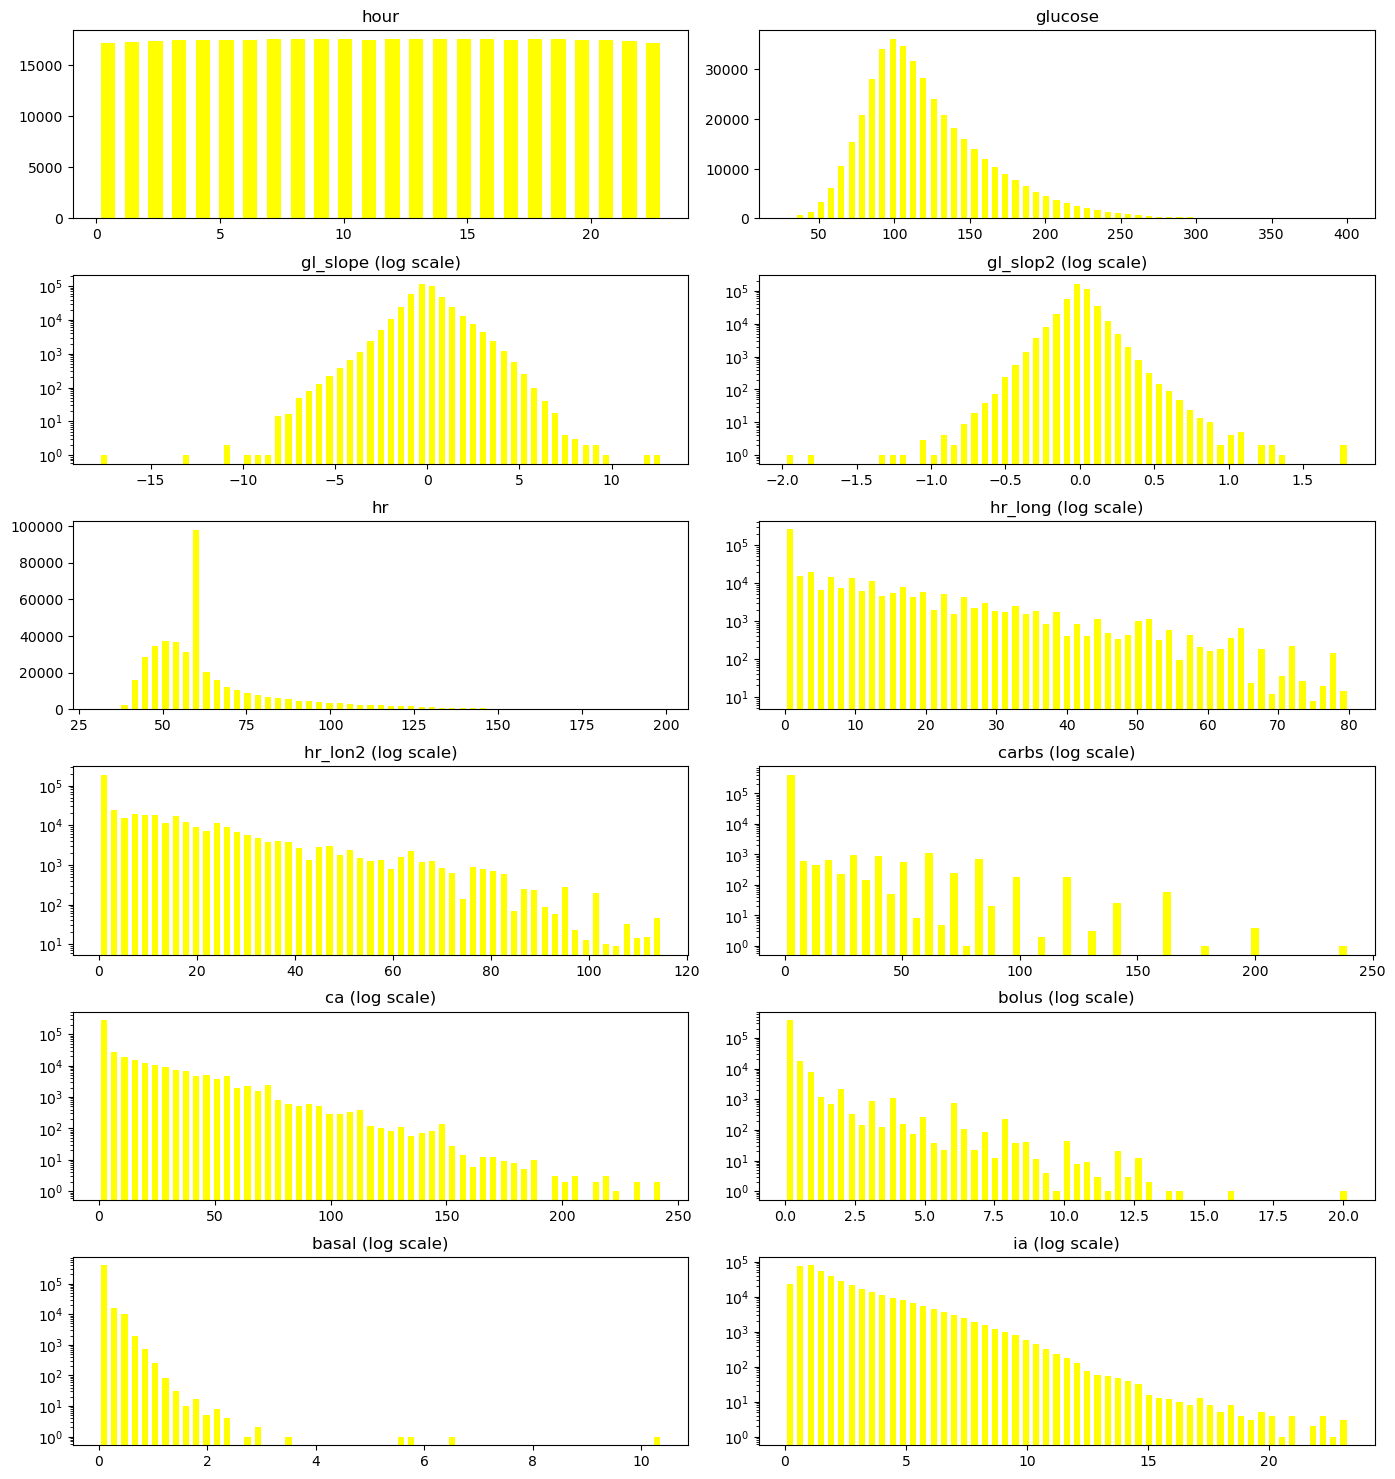

In [11]:
#@title Data Statistics
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))


def statistics(self):
  self.glucose.describe()
  no_log_features = ['hour', 'glucose', 'glucose1', 'gl_pred', 'hr']

  fig, axs = plt.subplots(nrows=(len(self.glucose.columns)+1) // 2, ncols=2, figsize=(14, 15))
  fig.tight_layout(pad=2.0)
  axs = axs.flatten()
  for i, c in enumerate(self.glucose.columns):
    col = self.glucose[c]
    log = c not in no_log_features
    axs[i].hist(
        x=col.values, log=log, bins=min(col.nunique(), 55),
        label=c, rwidth=0.6, color='yellow')
    axs[i].set_title(c + (' (log scale)' if log else ''))

M.statistics=statistics
m.statistics()

In [12]:
# #@title Experimental Insulin Action

# import tensorflow_probability as tfp

# df = m.glucose.copy()
# df['minute15'] = df.index.map(lambda ts: ts.replace(minute=15 * (ts.minute // 15)))


# df - df.groupby(by=['minute15']).mean()



# td = timedelta(minutes=120)
# tdc = timedelta(minutes=60)

# window_th = 0.3

# bolus = df.bolus > 3

# # indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=td)
# window_bolus = (df
#       .bolus.map(lambda b: b if b > window_th else 0.0)
#       .rolling(window=tdc, center=False)
#       #.apply(lambda b: b[b > window_th]
#       .sum())
# window_carbs = (df
#       .carbs
#       .rolling(window=2*td, center=True)
#       #.apply(lambda b: b[b > window_th]
#       .sum())

# df['clean_bolus'] = (df.bolus == window_bolus) & bolus & (window_carbs < 0.1)

# ts = None
# gl = None
# points = []
# means = []
# modes = []
# for row in df.itertuples():
#   if row.clean_bolus:
#     ts = row.Index
#     gl = row.glucose
#     #print('Start %s bolus=%f' % (str(ts), row.bolus))
#   elif ts is not None and row.Index - ts < td:
#     minutes = int((row.Index-ts)/timedelta(minutes=1))
#     # print('Cont %s bolus=%f slope=%f' % (str(minutes), row.bolus, row.glucose))
#     points.append(row.glucose - gl)
#   elif len(points) > 0 and len(points) > 10:
#     ln = tfp.distributions.LogNormal.experimental_fit(points)
#     mean = ln.mean().numpy()
#     if not np.isnan(mean):
#       means.append(mean)
#       modes.append(ln.mode().numpy() / 12)
#       print('Mean: %f mode: %f' % (mean, ln.mode().numpy() / 4))
#     points = []
#   else:
#     points = []

# pd.Series(modes).median()

# # print('ln %f %f' % (ln.loc, ln.scale))

In [13]:
# ln = tfp.distributions.LogNormal.experimental_fit([1., 2., 1.])

# print(ln)


# print(ln.mean().numpy())
# print(ln.variance().numpy())



# data = ln.sample(10)
# ln1 = tfp.distributions.LogNormal(1, 1)
# data=ln1.sample(100)

# x = np.linspace(0, 10, 100, dtype=np.float64)
# plt.scatter(x=x, y=ln.prob(x), color='red', alpha=0.4)

# # ln1.log_prob([1,2])
# ln1.prob(x)

In [14]:
#@title Adjust for Level Dependent Insulin Sensitivity

def adjust_insulin_sensitivity(self, glucose=None, threshold=60):
  if glucose is None: glucose = self.glucose
  glucose.ia = glucose.ia * glucose.glucose.apply(lambda g: 1 if g > threshold else 1.5)
M.adjust_insulin_sensitivity = adjust_insulin_sensitivity
del adjust_insulin_sensitivity

# m.adjust_insulin_sensitivity()

# Setup and Train Model

In [15]:
def value_col_name(n, m):
  if n == 'glucose': n = 'gl'
  elif n == 'gl_slope': n = 'gls'
  elif n == 'gl_slop2': n = 'gls2'
  elif n == 'heart_rate': n = 'hr'
  return '%s_%03d' % (n, m)
def gl_col_name(m): return value_col_name('glucose', m)
def gl_slope_col_name(m): return value_col_name('gl_slope', m)
def ia_col_name(m): return value_col_name('ia', m)
def ca_col_name(m): return value_col_name('ca', m)
def hr_col_name(m): return value_col_name('hr', m)

In [16]:
#@title Pivot Input
def datetime_to_period(self, dt):
  day = dt.floor('D')
  t = dt - day
  return day + self.PERIOD * (t // self.PERIOD)
def datetime_to_period(self, dt, start_ts):
  t = dt - start_ts
  p = self.PERIOD * (t // self.PERIOD)
  return p + start_ts
M.datetime_to_period = datetime_to_period

M.xy_cols = ['gl_slope', 'gl_slop2']
M.x_cols = ['hour', 'ia', 'ca', 'hr']
M.feature_min_cols = ['glucose'] + M.xy_cols + M.x_cols

M.x_cols_train = ['hour', 'ia', 'ca', 'hr']

@property
def x_min_cols(self):
  return self.xy_cols + self.x_cols_train
M.x_min_cols = x_min_cols
del x_min_cols

@property
def feature_cols(self):
  return self.feature_min_cols + self.HR_LONG_COLS
M.feature_cols = feature_cols
del feature_cols

@property
def all_cols(self):
  return ['hour'] + self.x_min_cols + self.HR_LONG_COLS
M.all_cols = all_cols
del all_cols

def pivot_for_model(self, gl=None, start_ts=None):
  df = (self.glucose if gl is None else gl).copy()
  start_ts = self.start_ts if start_ts is None else start_ts
  df['minute'] = df.index.map(
      lambda dt: self.FREQ_MINUTES * ((dt - self.datetime_to_period(dt, start_ts)) // self.FREQ))
  df.index = df.index.map(lambda ts: self.datetime_to_period(ts, start_ts))
  df.reset_index(inplace=True)

  # Aggregate values, usually we get a single value. Compute the mean if there
  # are multiple.
  def agg(x):
    return float(x if pd.api.types.is_scalar(x) else sum(x) / len(x))
  df = pd.pivot_table(
      df, index=['date'], columns='minute',
      values=self.feature_cols,
      aggfunc=dict(hour='min', **{v: agg for v in self.feature_cols if v != 'hour'}))
  # Lift the sub-columns up, e.g. rename df['glucose'][5] to df['glucose_005']
  r = pd.concat({
      #  **{value_col_name('hour', m): df['hour'][m],
       **{value_col_name(v, m): df[v][m] for v in self.feature_min_cols for m in self.PERIOD_MINUTES},
       **{hr_long: df[hr_long][self.PERIOD_MINUTES[-1]] for hr_long in self.HR_LONG_COLS}},
      axis=1).dropna()
  if gl is None: self.input = r
  return r
M.pivot_for_model = pivot_for_model
del pivot_for_model

def order_cols(df, cols, fill):
  o = df.copy()
  if fill is None:
    cols = [c for c in cols if c in df.columns]
  else:
    for c in cols:
      if c not in df.columns:
        o[c] = fill
  return o[cols].copy()

def order_cols_fm(self, df, min_cols):
  cols = [value_col_name(c, m) for c in min_cols for m in self.PERIOD_MINUTES]
  return order_cols(df, ['hour'] + cols + self.HR_LONG_COLS, fill=0.0)
M.order_cols_fm = order_cols_fm
del order_cols_fm

def order_cols_mf(self, df, min_cols):
  min_cols = [value_col_name(c, m)  for m in self.PERIOD_MINUTES for c in min_cols]
  return order_cols(df, ['hour'] + min_cols + self.HR_LONG_COLS, fill=0.0)
M.order_cols_mf = order_cols_mf
del order_cols_mf

def pivot_input(self):
  def pivot(df):
    input = pd.concat(
        [ self.pivot_for_model(
            df[h * 12:],
            start_ts=self.start_ts + timedelta(hours=h))
          for h in range(0, (self.TRAIN_MINUTES + self.PRED_MINUTES) // 60)])
    return input.sort_index()
  # self.validation_input = pivot(self.glucose)
  self.input = pivot(smooth_glucose(self.glucose.copy()))
M.pivot_input = pivot_input
del pivot_input

m.pivot_input()
print('input shape %s' % str(m.input.shape))
# data_table.DataTable(m.input.head(2000), max_columns=100)
m.input.describe().T

input shape (34231, 338)


count        mean        std  ...         50%         75%         max
gl_000   34231.0  121.235997  41.409845  ...  112.792135  142.961631  401.000000
gl_005   34231.0  121.216944  41.458932  ...  112.716674  143.093561  401.538411
gl_010   34231.0  121.211821  41.503402  ...  112.742985  142.950022  402.385088
gl_015   34231.0  121.204813  41.542714  ...  112.647536  142.820234  401.377167
gl_020   34231.0  121.200623  41.568914  ...  112.471253  142.851673  401.185381
...          ...         ...        ...  ...         ...         ...         ...
hr_225   34231.0   63.121894  18.827149  ...   60.000000   66.400000  170.230000
hr_230   34231.0   63.161620  18.818746  ...   60.000000   66.552320  168.770000
hr_235   34231.0   63.296184  18.890472  ...   60.000000   66.778700  174.127090
hr_long  34231.0    5.893897  11.024145  ...    0.000000    8.000000   80.000000
hr_lon2  34231.0   11.767667  16.754924  ...    4.000000   17.000000  114.000000

[338 rows x 8 columns]

In [17]:
#@title Split Training, Prediction, and Validation Data

M.predict_accumulated_slope = False
M.batch_size = 1  # redefined later

def take_batches(self, df):
  return df[:self.batch_size * (df.shape[0] // self.batch_size)]
M.take_batches = take_batches
del take_batches

@property
def train(self, df=None):
  if df is None: df = self.input
  return df[df.index < self.validation_start]
M.train = train
del train

@property
def validation(self, df=None):
  if df is None: df = self.input
  return self.take_batches(df[df.index >= self.validation_start])
M.validation = validation
del validation

def x_data_dense(self, df):
  return df.reset_index().filter(
    ['hour'] + self.HR_LONG_COLS +
    [value_col_name(v, m) for v in self.xy_cols for m in self.PERIOD_X_MINUTES] +
    [value_col_name(v, m) for v in self.x_cols for m in self.PERIOD_MINUTES])
M.x_data_dense = x_data_dense
del x_data_dense

def x_data_conv(self, df):
  df = df.reset_index()
  r = df.filter(
    [value_col_name(v, m) for v in ['hour'] + self.x_cols_train for m in self.PERIOD_MINUTES]).copy()
  for c in self.xy_cols:
    for m in self.PERIOD_X_MINUTES:
      r[value_col_name(c, m)] = df[value_col_name(c, m)]
    for m in self.PERIOD_Y_MINUTES:
      r[value_col_name(c, m)] = 0 # df[ca_col_name(m)] - df[ia_col_name(m)]
  for c in self.HR_LONG_COLS:
    r[c] = df[c]
  return r
M.x_data_conv = x_data_conv
del x_data_conv

def x_data(self, df):
  if self.use_conv:
    return self.x_data_conv(df)
  else:
    return self.x_data_dense(df)
M.x_data = x_data
del x_data

def y_data(self, df):
  y = df.reset_index().filter([gl_slope_col_name(m) for m in self.PERIOD_Y_MINUTES])
  if self.predict_accumulated_slope:
    return y.cumsum(axis=1)
  else:
    return y

  return y
M.y_data = y_data
del y_data

m.x_data(m.input).head(10)

hr_long  hr_lon2   gls_000   gls_005  ...  hr_220  hr_225  hr_230  hr_235
0      0.0      0.0 -0.196018 -0.718968  ...    60.0    60.0    60.0    60.0
1      0.0      0.0 -0.531371 -0.867780  ...    60.0    60.0    60.0    60.0
2      0.0      0.0 -1.737999 -0.029581  ...    60.0    60.0    60.0    60.0
3      0.0      0.0  0.191625 -0.281703  ...    60.0    60.0    60.0    60.0
4      0.0      0.0  0.683676  0.612390  ...    60.0    60.0    60.0    60.0
5      0.0      0.0  1.097117  1.000382  ...    60.0    60.0    60.0    60.0
6      0.0      0.0 -0.795210 -1.588164  ...    60.0    60.0    60.0    60.0
7      0.0      0.0 -0.504761  0.595408  ...    60.0    60.0    60.0    60.0
8      0.0      0.0  0.043568 -0.007940  ...    60.0    60.0    60.0    60.0
9      0.0      0.0 -0.226565 -0.124351  ...    60.0    60.0    60.0    60.0

[10 rows x 266 columns]

<Axes: >

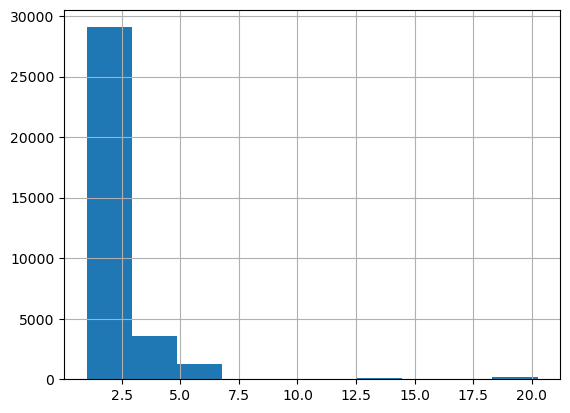

In [18]:
#@title Sample Weights

M.low_glucose = 70
M.high_glucose = 150
M.turn_slope_th = 1
M.low_weight = 3
M.high_weight = 2
M.turn_weight = 1.5
M.critical_slope = 1.3
M.critical_slope_weight = 1.5
M.active_weight = 3

@property
def last_glucose_col(self):
  return gl_col_name(self.PERIOD_X_MINUTES[-1])
M.last_glucose_col = last_glucose_col

@property
def y_glucose_cols(self):
  return list(map(gl_col_name, self.PERIOD_Y_MINUTES))
M.y_glucose_cols = y_glucose_cols

@property
def gl_slope_cols(self):
  return list(map(gl_slope_col_name, self.PERIOD_Y_MINUTES))
M.gl_slope_cols = gl_slope_cols

@property
def hr_cols(self):
  return list(map(hr_col_name, self.PERIOD_MINUTES))
M.hr_cols = hr_cols
del hr_cols

def active(self, df):
  return df[self.hr_cols].mean() > 90
M.active = active
del active

def compute_sample_weight(self):
  def m(y):
    predict_low = (
        y[self.y_glucose_cols].min() < self.low_glucose and
        y[self.last_glucose_col] > self.low_glucose)
    predict_dec = (
        y[self.last_glucose_col] >  self.critical_slope * y[self.y_glucose_cols].min())
    predict_inc = (
        y[self.last_glucose_col] <  y[self.y_glucose_cols].max() / self.critical_slope)
    predict_turn = (
        y[self.gl_slope_cols].min() < -self.turn_slope_th and
        y[self.gl_slope_cols].max() > self.turn_slope_th)
    active = self.active(y)
    weight = self.low_weight if predict_low else 1
    weight *= self.critical_slope_weight if (predict_dec | predict_inc) else 1
    weight *= self.active_weight if active else 1
    weight = weight * (self.turn_weight if predict_turn else 1)
    return weight
  self.input['sample_weight'] = self.input.apply(m, axis=1)
M.compute_sample_weight = compute_sample_weight
m.compute_sample_weight()

m.input.sample_weight.hist()

In [70]:
#@title Predict Values

def predict(self, features, add_glucose=False):
  v = self.take_batches(features)
  x = self.x_data(v)
  pred_arrays = self.model.predict(x, verbose=0, batch_size=self.batch_size).transpose()
  prediction = pd.DataFrame(index=v.index)
  prev = 0.0
  for i, m in enumerate(self.PERIOD_Y_MINUTES):
    prediction[gl_slope_col_name(m)] = pred_arrays[i] - prev
    if self.predict_accumulated_slope:
      prev = pred_arrays[i]

  if (add_glucose):
    last_value_m = self.PERIOD_X_MINUTES[-1]
    last_glucose_col = gl_col_name(self.PERIOD_X_MINUTES[-1])
    prediction[last_glucose_col] = v[last_glucose_col]
    s = v[last_glucose_col]
    freq = self.FREQ_MINUTES
    for m in self.PERIOD_Y_MINUTES:
      gls = prediction[gl_slope_col_name(m)]
      prediction[gl_col_name(m)] = \
          (m - last_value_m) * gls + prediction[gl_col_name(last_value_m)]
      prediction[gl_col_name(m)].clip(lower=30, upper=300, inplace=True)
      if not self.predict_accumulated_slope:
        last_value_m = m

  return prediction
M.predict = predict
del predict

In [44]:
#@title Metrics Logging
import contextlib
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

def minutes_to_label(self, minutes):
  return minutes + self.TRAIN_MINUTES - self.FREQ_MINUTES
M._minutes_to_label = minutes_to_label

class NullCtxMgr(contextlib.AbstractContextManager):
  def __exit__(self, *args):
    pass

M.tf_writer = None
def log_accuracy(self, epoch, logs):
  if epoch % 5 != 0: return
  data = self.take_batches(self.validation)
  p = self.predict(data, True)
  assert data.shape[0] == p.shape[0]
  with self.tf_writer.as_default():
    for minutes in (30, 60):
      col = gl_slope_col_name(self._minutes_to_label(minutes))
      err = (data[col] - p[col]).abs().mean()
      tf.summary.scalar('slope accuracy %d min' % minutes, err, step=epoch)
      self.metrics.setdefault('sl_acc_%d' % minutes, []).append(err)

      col = gl_col_name(self._minutes_to_label(minutes))
      gerr = mean_absolute_error(data[col], p[col])
      tf.summary.scalar('glucose accuracy %d min' % minutes, gerr, step=epoch)
      self.metrics.setdefault('gl_acc_%d' % minutes, []).append(gerr)
      grerr = 100 * mean_absolute_percentage_error(data[col], p[col])
      tf.summary.scalar('glucose accuracy %% %d min' % minutes, grerr, step=epoch)
      self.metrics.setdefault('gl_acc%%_%d' % minutes, []).append(grerr)
      stdev = (data[col] - p[col]).abs().std()
      tf.summary.scalar('glucose stddev %d min' % minutes, stdev, step=epoch)
      self.metrics.setdefault('stdev_%d' % minutes, []).append(stdev)

M._log_accuracy = log_accuracy

# m._log_accuracy(5, None)
# m.predict(m.validation, True)

In [21]:
#@title Model Helpers

def layer_short_name(l):
  if isinstance(l, tf.keras.layers.Normalization):
    return 'N'
  elif isinstance(l, tf.keras.layers.Dense):
    return 'D(%d)' % l.units
  elif isinstance(l, tf.keras.layers.Conv1D):
    return 'Conv(%d,%s)' % (l.filters, l.kernel_size)
  elif isinstance(l, tf.keras.layers.Conv1DTranspose):
    return 'ConvT(%d,%s)' % (l.filters, l.kernel_size)
  elif isinstance(l, tf.keras.layers.ConvLSTM1D):
    return 'ConvL(%d,%s)' % (l.filters, l.kernel_size)
  elif isinstance(l, tf.keras.layers.Dropout):
    return 'Drop(%.2f)' % l.rate
  else:
    return l.name[:2]

def concat_layers(n, input, layers, o):
  o.append('[')
  sep = ''
  out = []
  for l in layers:
    o.append(sep)
    out.append(seq_layers(n, input, l, o))
    sep = '|'
  o.append(']')
  return tf.keras.layers.concatenate(out)

def seq_layers(n, input, layers, o):
  c = input
  layers = layers if isinstance(layers, list) else [layers]
  for l in layers:
    if isinstance(l, list):
      c = concat_layers(n + '  ', c, l, o)
    else:
      o.append(layer_short_name(l))
      c = l(c)
      print('%s%s %s' % (n, l.name, getattr(c, 'shape', '-')))
  return c


In [22]:
m.x_data(m.train).head(10).T



0          1          2  ...          7          8          9
hr_long   0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000
hr_lon2   0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000
gls_000  -0.196018  -0.531371  -1.737999  ...  -0.504761   0.043568  -0.226565
gls_005  -0.718968  -0.867780  -0.029581  ...   0.595408  -0.007940  -0.124351
gls_010   0.615448  -1.110837   0.926089  ...   1.224036  -0.152297  -0.123268
...            ...        ...        ...  ...        ...        ...        ...
hr_215   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_220   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_225   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_230   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_235   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000

[266 rows x 10 columns]

2024-02-29 18:01:39.518814: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


normalization (64, 290)
  Reshape_1 (64, 290, 1)
  Crop_1 (64, 288, 1)
  Reshape_2 (64, 6, 48)
  Permute (64, 48, 6)
  Conv_1 (64, 95, 200)
  Reshape_3 (64, 19000)
  Dense_C2 (64, 200)
  Dense_D1 (64, 300)
Dense_O (64, 12)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(64, 290)]          0           []                               
                                                                                                  
 normalization (Normalization)  (64, 290)            581         ['Input[0][0]']                  
                                                                                                  
 Reshape_1 (Reshape)            (64, 290, 1)         0           ['normalization[0][0]']          
                                                                     

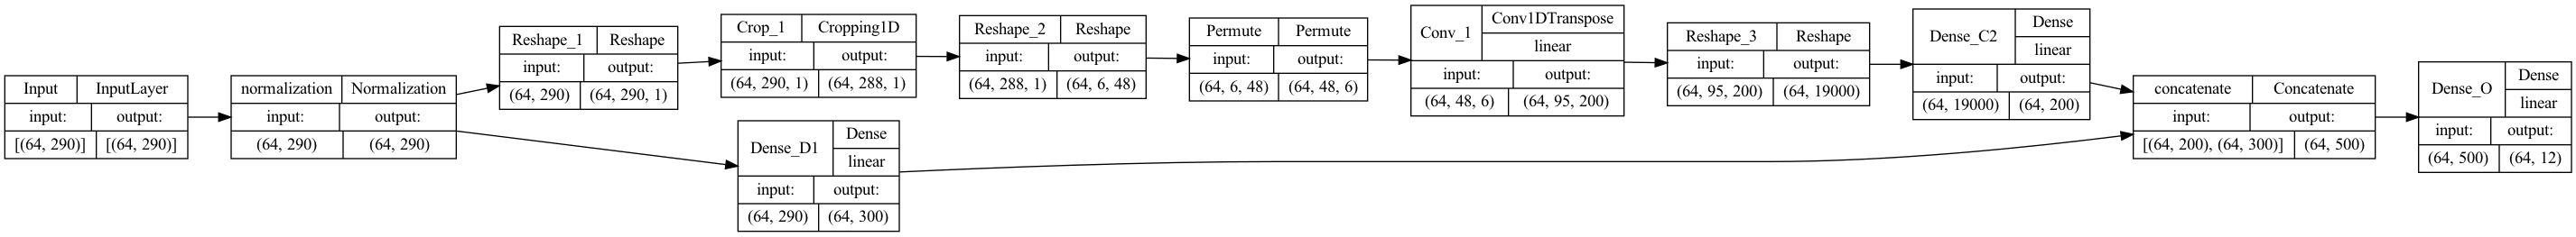

In [23]:
#@title Create Model
M.batch_size = 64

def create_model_conv(self):
  x = self.x_data_conv(self.train)
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(x)

  min_feature_cnt = len(self.x_min_cols)
  min_cnt = len(self.PERIOD_MINUTES)

  conv1_size = 200
  layers = [
    normalizer,
    [
      [ # Remove hour and hr_long* features.
        tf.keras.layers.Reshape((x.shape[1],1), name='Reshape_1'),
        tf.keras.layers.Cropping1D(cropping=(0, 2), name='Crop_1'),
        # Put all values with the same timestamp in one sub-vector.
        tf.keras.layers.Reshape((min_feature_cnt, min_cnt), name='Reshape_2'),
        tf.keras.layers.Permute((2, 1), name='Permute'),
        tf.keras.layers.Conv1DTranspose(
            name='Conv_1',
            filters=conv1_size,
            kernel_size=min_cnt,
            input_shape=(None, 1, min_cnt, min_feature_cnt)),
        tf.keras.layers.Reshape(((2 * min_cnt -1) * conv1_size,), name='Reshape_3'),
        # tf.keras.layers.SimpleRNN(
        #     name='RNN_1',
        #     activation=None,
        #     stateful=True,
        #     return_state=False,
        #     units=conv1_size),
        tf.keras.layers.Dense(name='Dense_C2', units=200),
      ],
      [ tf.keras.layers.Dense(300, name='Dense_D1') ],
    ],
    tf.keras.layers.Dense(self.y_data(self.train).shape[1], name='Dense_O'),
  ]

  input_layer = tf.keras.layers.Input(
      shape=x.shape[1:], name='Input', batch_size=self.batch_size)
  o = [layer_short_name(input_layer)]
  l = seq_layers('', input_layer, layers, o)
  return ''.join(o), keras.Model(inputs=[input_layer], outputs=[l])

M.create_model_conv = create_model_conv
del create_model_conv

def create_model_dense(self):
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(self.x_data(self.input))
  return tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(self.x_data(self.train).shape[1],)),
    normalizer,
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=400),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=self.y_data(self.train).shape[1])])
M.create_model_dense = create_model_dense
del create_model_dense

def create_model(self):
  if self.use_conv:
    return self.create_model_conv()
  else:
    return self.create_model_dense()
M.create_model = create_model
del create_model

mn, model = m.create_model_conv()
model.summary()
print('model: %s' % mn)
tf.keras.utils.plot_model(
    model,
    rankdir='LR',  # remove for larger image
    show_shapes=True,
    show_layer_activations=True)

In [24]:
# np.random.shuffle(
t = m.train[:9].copy()
index_list = np.array(t.index)
np.random.shuffle(np.reshape(index_list, (-1, 3)))
t.loc[index_list, :]
# x = t.values.reshape(-1, 3, t.shape[1])
# np.random.shuffle(x)
# t.values = x.reshape(-1, t.shape[1])


m.x_data(m.train).head(10).T


0          1          2  ...          7          8          9
hr_long   0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000
hr_lon2   0.000000   0.000000   0.000000  ...   0.000000   0.000000   0.000000
gls_000  -0.196018  -0.531371  -1.737999  ...  -0.504761   0.043568  -0.226565
gls_005  -0.718968  -0.867780  -0.029581  ...   0.595408  -0.007940  -0.124351
gls_010   0.615448  -1.110837   0.926089  ...   1.224036  -0.152297  -0.123268
...            ...        ...        ...  ...        ...        ...        ...
hr_215   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_220   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_225   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_230   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000
hr_235   60.000000  60.000000  60.000000  ...  60.000000  60.000000  60.000000

[266 rows x 10 columns]

In [25]:
def active_metrics(self):
  active = self.validation[self.hr_cols].mean(axis=1) > 90
  t = self.validation[active].shape[0]
  print('active rows: %d of %d' % (t, self.validation.shape[0]))
  v = self.take_batches(self.validation[active])
  pred_active = self.predict(v, True)
  col = value_col_name('gl', 30 + self.TRAIN_MINUTES - self.FREQ_MINUTES)
  active_mae = mean_absolute_error(pred_active[col], v[col])
  return active_mae
M.active_metrics = active_metrics
del active_metrics

# m.active_metrics()

In [ ]:
%%time
#@title Train Model

M.epochs = 50
M.validation_split = 0.2

M.log_base = os.path.join('/tmp', 'fitlogs')
M.use_conv = True

M.optimizer_args = {'learning_rate': 0.0005, 'beta_1': 0.9, 'beta_2': 0.999}
M.optimizer_mnemonic = 'lAdam'
M.optimizer = tf.keras.optimizers.legacy.Adam
M.loss_args = {'delta': 1.0}
M.loss_mnemonic = 'H'
M.loss = tf.keras.losses.Huber
m.predict_accumulated_slope = False
M.shuffle_input = True

def error_at(self, f, m):
  col = value_col_name(f, m + self.TRAIN_MINUTES - self.FREQ_MINUTES)
  print('col %s' % col)
  return self.prediction[col] - self.validation[col]
M.error_at = error_at
del error_at

def train_model(self):
  self.x_cols_train = ['hour', 'ia']
  self.batch_size = 60
  print("train model '%s'" % self.name)
  mnemonic, self.model = self.create_model()
  self.model.compile(
    optimizer=self.optimizer(**self.optimizer_args),
    metrics=['mse', 'mae', keras.metrics.LogCoshError(name="logcosh", dtype=None)],
    weighted_metrics=['mse'],
    loss=self.loss(**self.loss_args))

  self.metrics = {}
  log_dir = self.log_base + '/' + datetime.now().strftime("%Y-%m-%dT%H:%M")
  self.tf_writer = tf.summary.create_file_writer(log_dir)

  # align to batch size
  t = self.take_batches(self.train) #self.train.sample(frac=1)

  if self.shuffle_input:
    index_list = np.array(t.index)
    np.random.shuffle(np.reshape(index_list, (-1, self.batch_size)))
    t = t.loc[index_list, :]

  batch_count = t.shape[0] // self.batch_size
  v_split = self.batch_size * int(self.validation_split * batch_count)
  print('v_split %d' % v_split)
  v = t[:-v_split]
  t = t[-v_split:]

  print('training data %s validation %s' % (str(t.shape), str(v.shape)))

  self.history = self.model.fit(
      self.x_data(t),
      self.y_data(t),
      validation_data=(self.x_data(v), self.y_data(v)),
      shuffle=False,
      epochs=self.epochs,
      batch_size=self.batch_size,
      sample_weight=t.sample_weight.fillna(1.0).values,
      use_multiprocessing=True,
      callbacks=[
          tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
          keras.callbacks.LambdaCallback(on_epoch_end=self._log_accuracy)],
      verbose=0)
  self.metrics.update(self.history.history)
  with self.tf_writer.as_default():
    tf.summary.flush()
  self.tf_writer.close()
  self.tf_writer = None

  history_row = {
      'time': [pd.Timestamp.now()],
      'model': [mnemonic],
      'epochs': self.epochs,
      'batch': self.batch_size,
      'train': self.TRAIN_MINUTES,
      'loss': '%s(%s)' % (self.loss_mnemonic, str(self.loss_args)[1:-1]),
      'optimizer': '%s(%s)' % (self.optimizer_mnemonic, str(self.optimizer_args)[1:-1]),
      'start': self.START,
      'end': self.END,
      'train features': ', '.join(self.all_cols),
      'cum_slope': self.predict_accumulated_slope,
      'turn_weight': self.turn_weight,
      'low_weight': self.low_weight,
      'critical_slope_weight': self.critical_slope_weight,
      'shuffle': self.shuffle_input,
  }
  self.prediction = self.predict(self.validation, True)
  for f in ['gls', 'gl']:
    for m in [30, 60]:
      e = self.error_at(f, m).abs()
      k = '%s e%d'% (f, m)
      history_row[k] = [e.mean()]
      k = '%s std%d'% (f, m)
      history_row[k] = [e.std()]
  global history
  active_mae = self.active_metrics()
  history_row['act gl e30'] = active_mae

  history = pd.concat([pd.DataFrame(history_row), history], ignore_index=True)
M.train_model = train_model
del train_model

m.critical_slope_weight = 1
m.turn_weigth = 4
m.use_conv = True
m.train_model()

history['batch'] = history['batch'].map(int)
history.to_csv(history_file, index=False)
history[['time', 'gls e30', 'gls e60', 'gl e30', 'gl e60', 'gl std30', 'act gl e30',
         'epochs', 'batch', 'train', 'loss', 'optimizer', 'start', 'end',
         'model', 'train features', 'turn_weight', 'low_weight', 'critical_slope_weight']]

train model 'default'
normalization_4 (60, 194)
  Reshape_1 (60, 194, 1)
  Crop_1 (60, 192, 1)
  Reshape_2 (60, 4, 48)
  Permute (60, 48, 4)
  Conv_1 (60, 95, 200)
  Reshape_3 (60, 19000)
  Dense_C2 (60, 200)
  Dense_D1 (60, 300)
Dense_O (60, 12)
v_split 6240
training data (6240, 339) validation (25080, 339)


# Model Evaluation

> Indented block



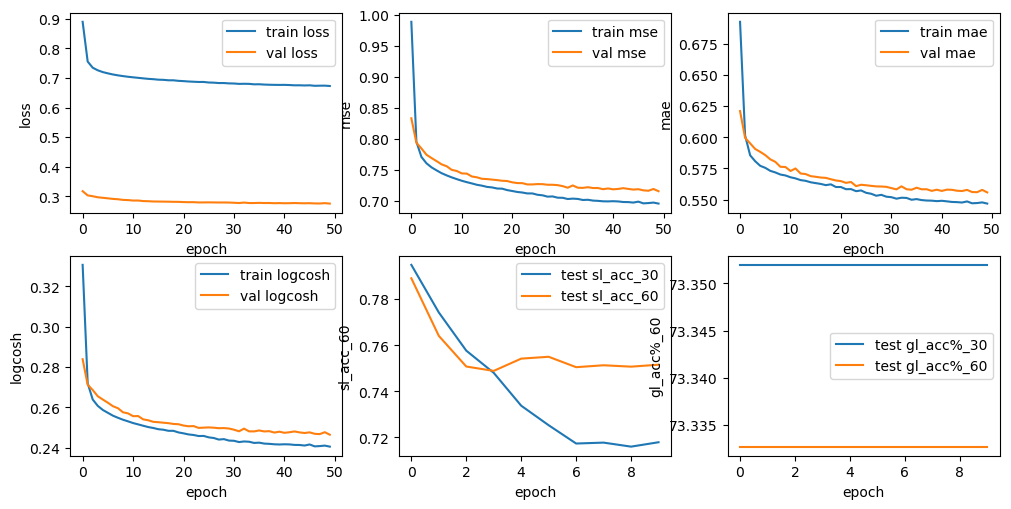

In [48]:
#@title Loss and Metrics

def plot_loss(self, ax, metric):
  if 'val_' + metric in self.metrics.keys():
    ax.plot(self.metrics[metric], label='train ' + metric)
    ax.plot(self.metrics['val_' + metric], label='val ' + metric)
  else:
    ax.plot(self.metrics[metric], label='test ' + metric)
  ax.set_xlabel('epoch')
  ax.set_ylabel(metric)
  ax.legend()
  ax.grid(False)
M.plot_loss = plot_loss

def plot_metrics(self):
  vmetrics = ['loss', 'mse', 'mae', 'logcosh']
  pmetrics = ['sl_acc', 'gl_acc%']
  c = len(vmetrics) + len(pmetrics)
  ncols = 3
  fig, axs = plt.subplots(ncols=ncols, nrows=(c+ncols-1)//ncols, subplot_kw={}, figsize=(10,5))
  axs = axs.flatten()
  fig.tight_layout(pad=1.0)
  for i, m in enumerate(vmetrics): self.plot_loss(axs[i], m)
  for i, m in enumerate(pmetrics):
    self.plot_loss(axs[i+len(vmetrics)], m + '_30')
    self.plot_loss(axs[i+len(vmetrics)], m + '_60')
M.plot_metrics = plot_metrics
del plot_metrics
m.plot_metrics()



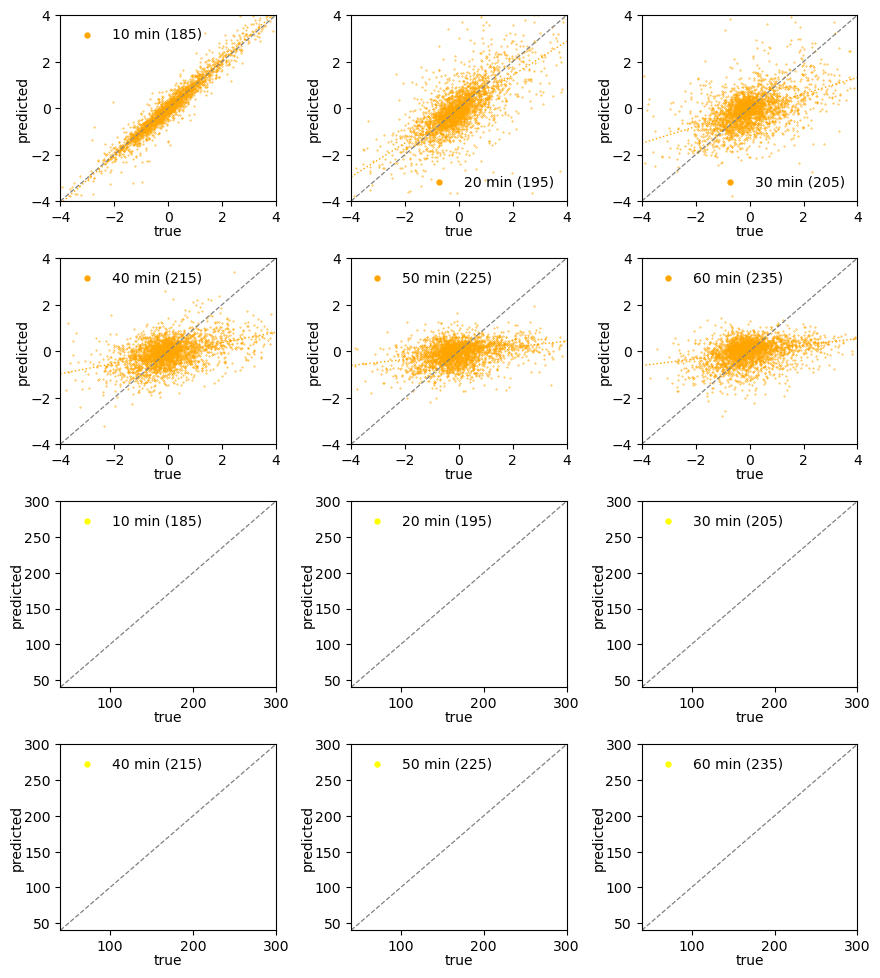

In [49]:
# @title True vs. Predicted Value Plots

def plot_linear_regression(ax, x_series, y_series, color, range):
  length = x_series.shape[0]
  p = np.polyfit(x_series.values, y_series.values, deg=1)
  x_ext = np.linspace(range[0], range[1], length)
  y_ext = np.poly1d(p)(x_ext)
  ax.plot(x_ext, y_ext, color=color, linewidth=1, linestyle='dotted')

def tp_scatter(self, ax, name, pred, true, color, range, minutes):
  m = minutes - self.TRAIN_MINUTES + self.FREQ_MINUTES
  ax.scatter(true[name], pred[name], s=0.5, marker='.', color=color, label='%d min (%d)' % (m, minutes))
  ax.set_xlabel('true', labelpad=0)
  ax.set_ylabel('predicted', labelpad=0)
  ax.set_xlim(range[0], range[1])
  ax.set_ylim(range[0], range[1])
  ax.set_xmargin(20)
  ax.set_label([name])
  ax.legend(markerscale=10, frameon=False)
  ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='grey', linestyle='--', linewidth=0.9)
  plot_linear_regression(ax, true[name], pred[name], color, range)
M._tp_scatter = tp_scatter


def true_pred_plots(self):
  fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={}, figsize=(9,10))
  fig.tight_layout(pad=2.0)
  for i, m in enumerate([m for m in self.PERIOD_Y_MINUTES[1::2]]):
    self._tp_scatter(axs[i//3][i%3], gl_slope_col_name(m), self.prediction, self.validation, color='orange', range=(-4, 4), minutes=m)
  for i, m in enumerate(self.PERIOD_Y_MINUTES[1::2]):
    self._tp_scatter(axs[2 + i//3][i%3], gl_col_name(m), self.prediction, self.validation, color='yellow', range=(40, 300), minutes=m)

M.true_pred_plots = true_pred_plots
m.true_pred_plots()

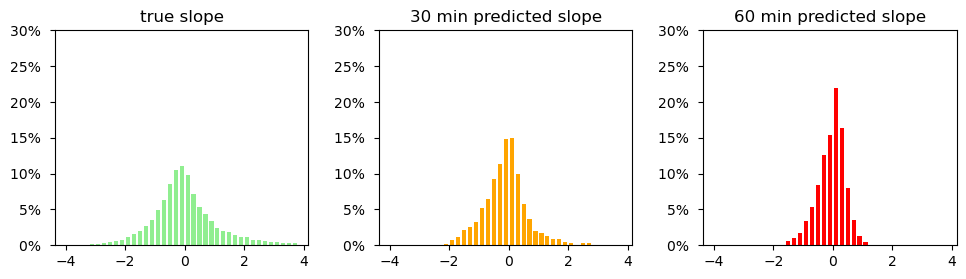

In [29]:
#@title True vs. Predicted Values Histogram
import matplotlib.colors as colors

def frange(f, t, s=1):
  def gen(f, t, s):
    while f < t:
      yield f
      f = round(f + s, 8)
  return list(gen(f, t, s))

def tp_histo(self):
  def hist(ax, x, color, title):
    ax.hist(x=x, bins=frange(-4, 4, 0.2), rwidth=0.7,
            color=color, weights=np.ones(len(x)) / len(x))
    ax.set_title(title)
    ax.set_ylim(0, 0.3)
    ax.yaxis.set_major_formatter(lambda y, _: '%d%% ' % int(100*y))
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
  fig.tight_layout(pad=2.0)
  axs = axs.flatten()
  hist(axs[0],
       x=self.glucose[(self.glucose.index >= self.validation_start)].gl_slope,
       color='lightgreen', title='true slope')
  hist(axs[1], x=self.prediction[gl_slope_col_name(self.TRAIN_MINUTES + 25)],
       color='orange', title='30 min predicted slope')
  hist(axs[2], x=self.prediction[gl_slope_col_name(self.TRAIN_MINUTES + 55)],
       color='red', title='60 min predicted slope')

M.tp_histo = tp_histo
del tp_histo
m.tp_histo()

mean absolute error: 0.6
mean absolute error perc: 72.2


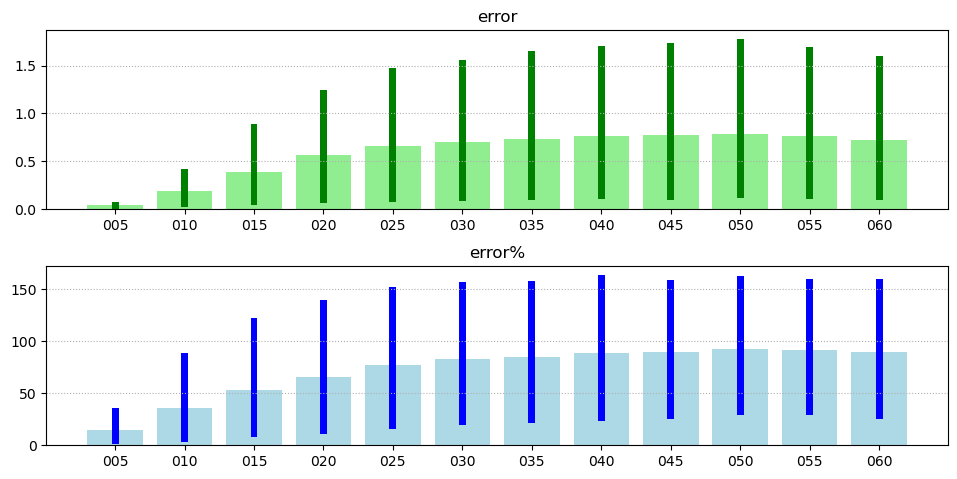

In [30]:
#@title Slope Mean Error and Error Quantiles

def print_errors(true, pred):
  abs_error = (pred - true).abs()
  mean_abs_error = abs_error.sum().sum() / pred.size
  mean_abs_errors = abs_error.sum() / pred.shape[0]

  maxv = pred.abs().where(pred.abs() > true.abs(), true.abs())
  abs_error_p = (100 * (pred - true)/maxv).abs()
  mean_abs_errors_p = abs_error_p.sum() / pred.shape[0]

  print("mean absolute error: %.01f" % mean_abs_error)
  print("mean absolute error perc: %.01f" % mean_abs_errors_p.mean())

  bar_labels = ['%03d' % m for m in range(5, 65, 5)]
  fig, axs = plt.subplots(nrows=2, subplot_kw={}, figsize=(10,5))
  fig.tight_layout(pad=2.0)

  ax = axs[0]
  ax.set_title("error")
  ax.bar(bar_labels, mean_abs_errors.values, color='lightgreen')
  ax.bar(bar_labels,
        (abs_error.quantile(q=0.9)-abs_error.quantile(q=0.1)).values,
        bottom=abs_error.quantile(q=0.1).values, width=0.1, color='green')
  ax.grid(True, which='major', axis='y', ls=':')
  ax = axs[1]
  ax.set_title("error%")
  ax.bar(bar_labels, mean_abs_errors_p.values, color='lightblue')
  ax.bar(bar_labels,
        (abs_error_p.quantile(q=0.9)-abs_error_p.quantile(q=0.1)).values,
        bottom=abs_error_p.quantile(q=0.1).values, width=0.1, color='blue')
  ax.grid(True, which='major', axis='y', ls=':')

  cols = {'%s %.0f%%-ile' % (n, 100 * q): ae.quantile(q=q) for n, ae in [('e', abs_error), ('e%', abs_error_p)] for q in [0.1, 0.5, 0.75, 0.9, 0.99]}
  cols['mean_abs_error'] = mean_abs_errors
  cols['mean_abs_error_p'] = mean_abs_errors_p
  return pd.DataFrame(cols)

def print_slope_errors(self):
  return print_errors(
      self.y_data(self.validation),
      self.prediction.reset_index().filter([gl_slope_col_name(m) for m in self.PERIOD_Y_MINUTES]))
M.print_slope_errors = print_slope_errors

data_table.DataTable(m.print_slope_errors())

mean absolute error: 12.2
mean absolute error perc: 9.1


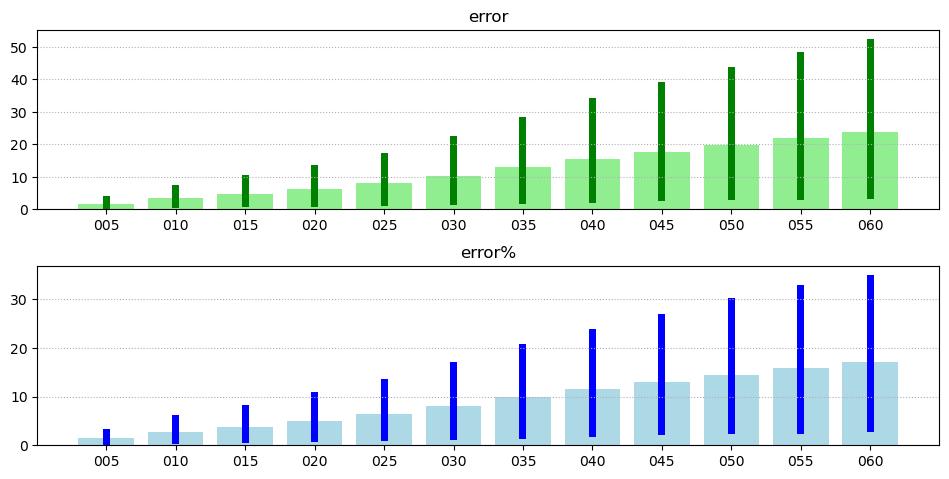

In [31]:
#@title Glucose Mean Error and Error Quantiles
def print_glucose_errors(self):
  return print_errors(
      self.validation.reset_index().filter([gl_col_name(m) for m in self.PERIOD_Y_MINUTES]),
      self.prediction.reset_index().filter([gl_col_name(m) for m in self.PERIOD_Y_MINUTES]))
M.print_glucose_errors = print_glucose_errors

data_table.DataTable(m.print_glucose_errors(), num_rows_per_page=100)

# Scenarios

In [32]:
#@title Add Prediction to Input

def add_prediction(self, gl=None, start_ts=None):
  input, glucose = (self.input, self.glucose) \
      if gl is None else (self.pivot_for_model(gl, start_ts=start_ts), gl)

  p = self.predict(input, add_glucose=True)
  p = p.filter([value_col_name(c, m)
      for c in ['gls', 'gl']
      for m in self.PERIOD_Y_MINUTES]).reset_index()
  p = pd.wide_to_long(p, stubnames=['gls_', 'gl_'], i='date', j='minute')
  p = p.reset_index()
  p['date'] = p.apply(lambda r: r.date + timedelta(minutes=r.minute), axis=1)
  p.pop('minute')
  p.rename({'gls_': 'gl_slope', 'gl_': 'glucose'}, inplace=True, axis=1)
  p.sort_values(by='date', inplace=True)
  p.set_index('date', inplace=True)
  glucose['gl_pred'] = p['glucose']
  return p

M.add_prediction = add_prediction
del add_prediction
m.add_prediction()

data_table.DataTable(m.glucose.head(2000))

In [33]:
#@title Timeline Date

start_date = '2023-11-09' # @param{type: 'date'}
days = 10 # @param{type:'slider', min: 0, max: 30}
tt = timedelta(days=days)
start = pd.to_datetime(start_date)

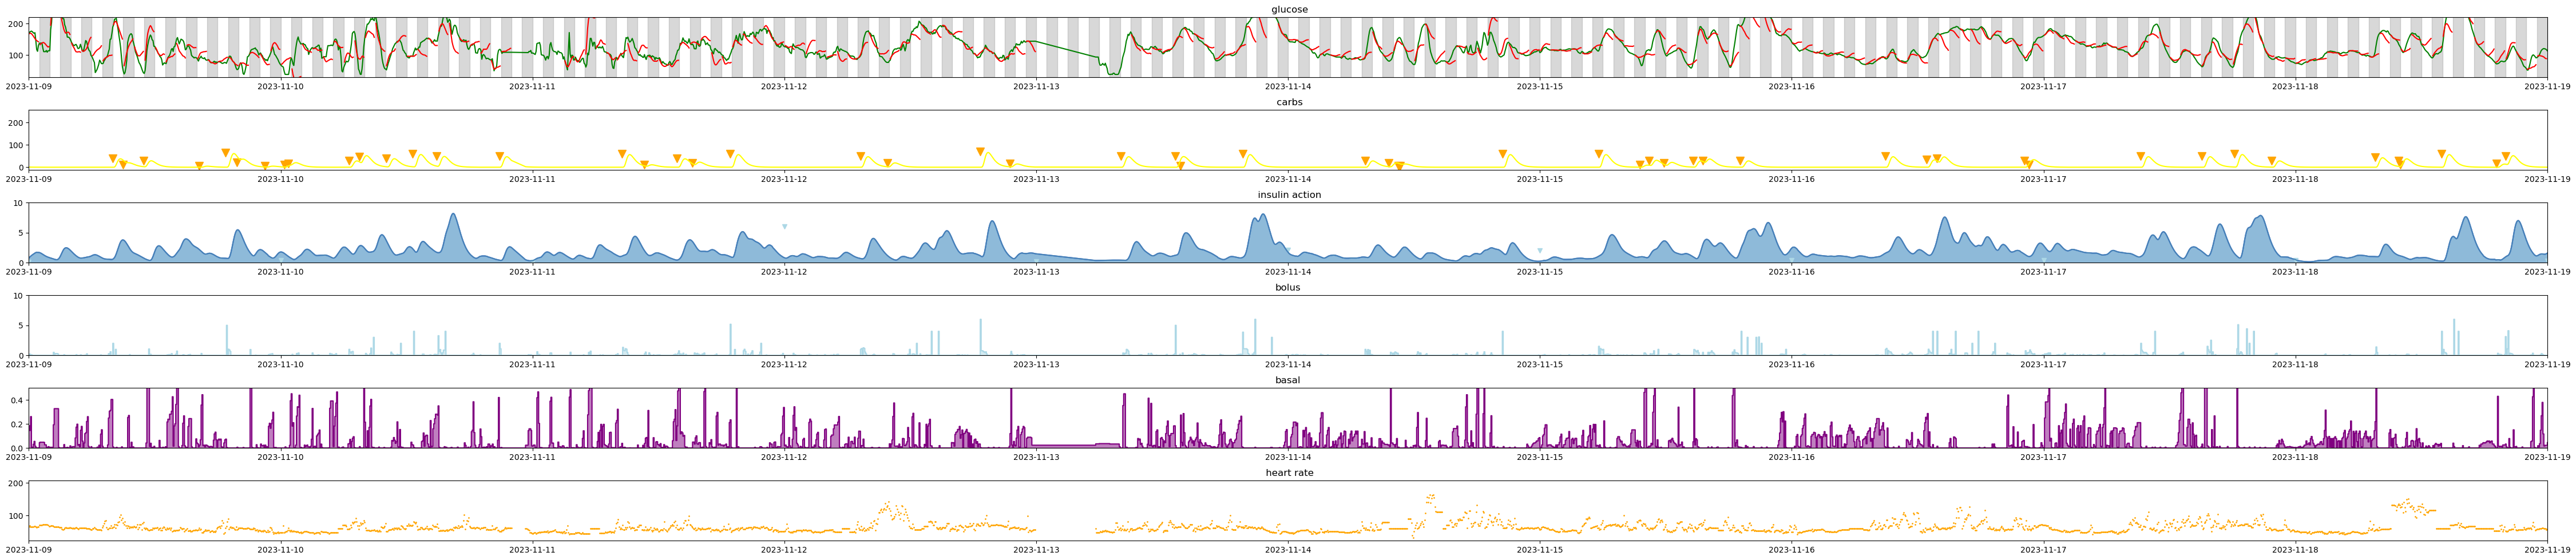

In [34]:
#@title History Timeline

date_range = start, start + tt

def plot_timeline(axs, gl, title=None, date_range=None, glucose_range=(30, 220)):
  carbs = gl[gl.carbs > 0]
  bolus =gl[gl.bolus > 0].reset_index()
  axs[0].set_ylim(glucose_range[0], glucose_range[1])
  axs[2].set_ylim(0, 10)
  date_range = date_range or (gl.index.min(), gl.index.max())
  for ax in axs: ax.set_xlim(date_range)
  axs[0].plot_date(gl.index, gl['glucose'], linestyle='-', markersize=0, color='green')
  axs[0].plot_date(gl.index, gl['gl_pred'], linestyle='-', markersize=0, color='red')
  for dt in pd.date_range(start=date_range[0], end=date_range[1], freq=timedelta(hours=2)):
    s = mdates.date2num(dt + timedelta(hours=1))
    e = mdates.date2num(dt + timedelta(hours=2))
    r = Rectangle((s, glucose_range[0]), e-s, glucose_range[1], color='grey', alpha=0.3)
    axs[0].add_patch(r)
  axs[1].plot_date(gl.index, gl['ca'], linestyle='-', markersize=0, color='yellow')
  axs[1].plot_date(carbs.index, carbs['carbs'], fmt='v', markersize=10, color='orange', zorder=1)
  axs[2].plot_date(gl.index, gl['ia'], linestyle='-', markersize=0, color='royalblue')
  axs[2].plot_date(bolus.index, bolus['bolus'], fmt='v', color='lightblue')
  axs[0].set_title("%s glucose" % (title or ''))
  axs[1].set_title("%s carbs" % (title or ''))
  axs[2].set_title("%s insulin action" % (title or ''))
  axs[-1].plot_date(
      gl.index, gl['hr'], linestyle='', markersize=1, color='orange')
  axs[-1].set_title("%s heart rate" % (title or ''))

def plot_basal(ax, x, y, color=None):
  ax.plot_date(
      x='x', y='y', color=color, data={'x':x,'y':y},
      drawstyle='steps-post', linestyle='-', markersize=0)
  ax.fill_between(x=x, y1=y, color=color, alpha=0.5, step='post')

def plot_history_timeline(self):
  x = self.glucose.copy()
  x.gl_pred = x.gl_pred.where(x.index.minute != 0)
  fig, axs = plt.subplots(nrows=6, subplot_kw={}, figsize=(45,10))
  fig.tight_layout(pad=2.0)
  plot_timeline(axs, x, date_range=date_range)
  axs[2].plot_date(
      self.glucose.index,
      self.glucose['ia'],
      linestyle='-',
      markersize=0, color='steelblue')
  axs[2].fill_between(self.glucose.index, self.glucose.ia, alpha=0.5)

  axs[3].set_title('bolus')
  plot_basal(axs[3], color='lightblue', x=self.glucose.index, y=self.glucose.bolus)
  axs[3].set_ylim(0, 10)
  axs[4].set_title('basal')
  plot_basal(axs[4], color='purple', x=self.glucose.index, y=self.glucose.basal)
  axs[4].set_ylim(0, 0.5)
M.plot_history_timeline = plot_history_timeline
del plot_history_timeline

m.plot_history_timeline()

plot const 80 mg/dl
plot constant 120 mg/dl
plot constant 120 mg/dl; 150 bpm
plot constant 170 mg/dl
plot 50g carbs
plot Inc glucose, 50g carbs
plot 5 I.U. insulin
plot 10 I.U. insulin
plot Inc glucose, 10 I.U. insulin


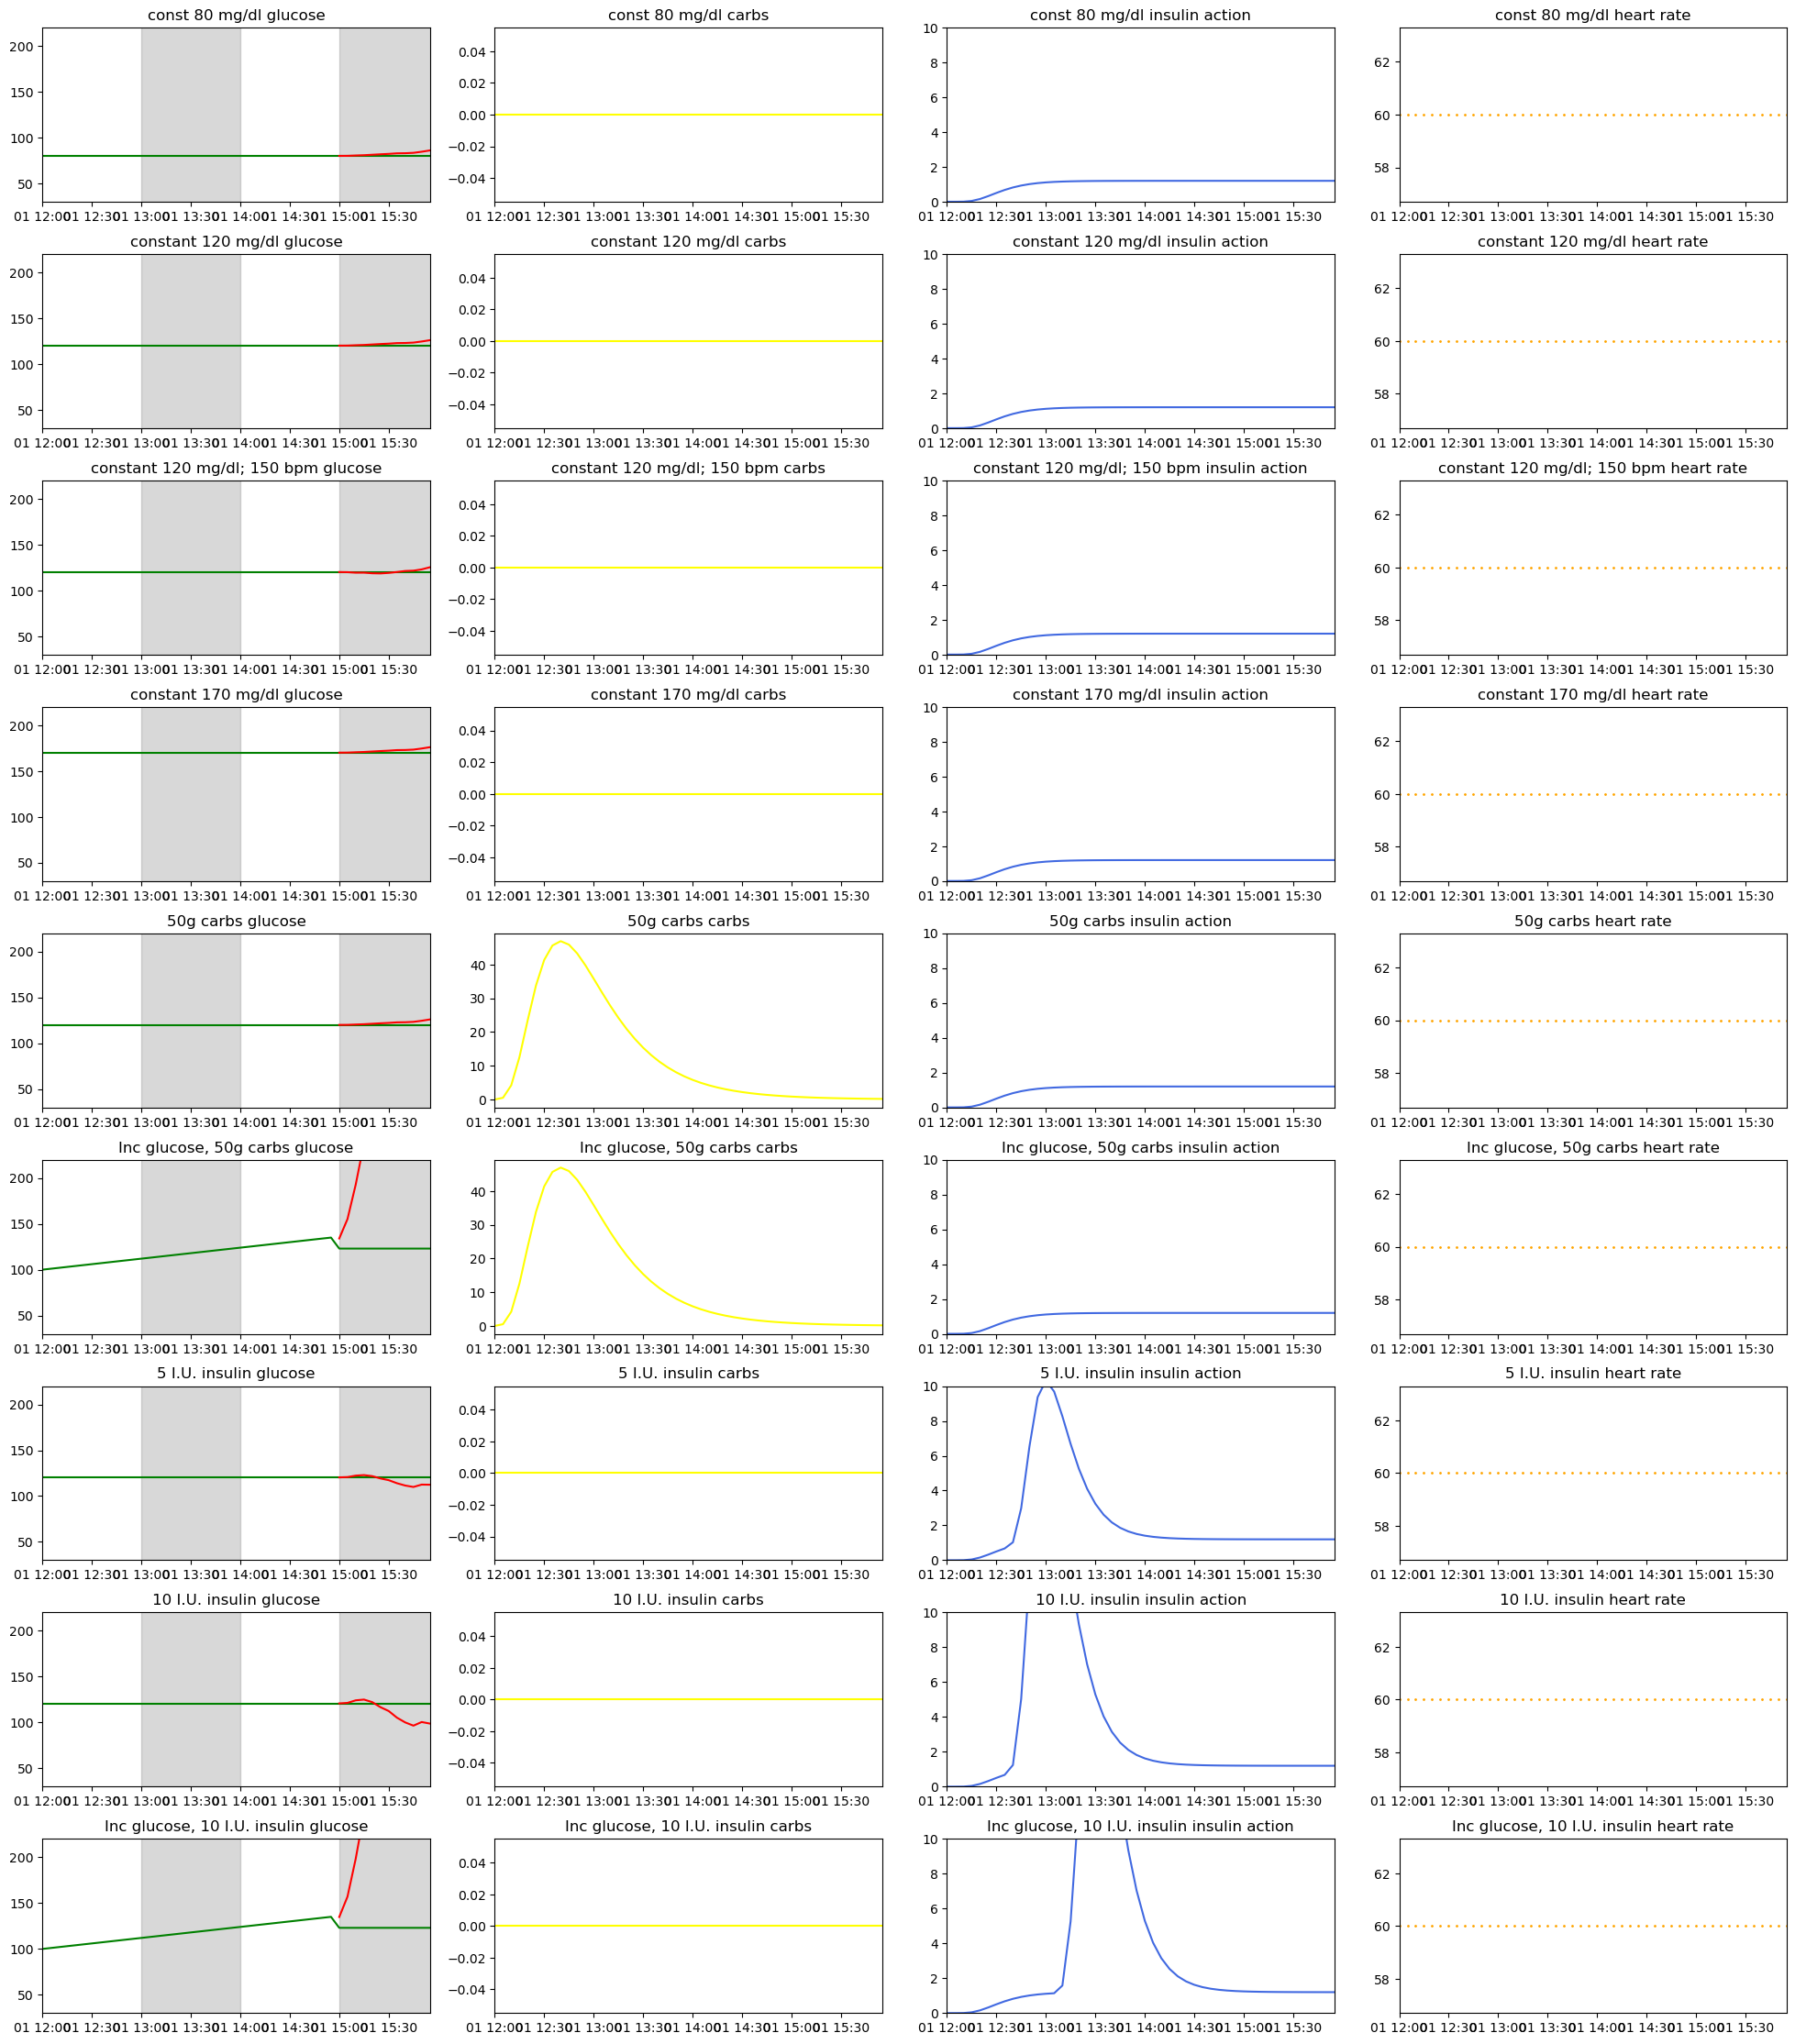

In [35]:
#@title Artificial Scenarios
m.test_data = []

def create_static_data(self, name, glucose, basal, carb_events, insulin_events, hr=60.0, hr_long=0.0):
  self.batch_size = 1
  row_count = len(self.PERIOD_MINUTES)
  if np.isscalar(glucose): glucose = row_count * [glucose]
  if np.isscalar(basal): basal = row_count * [basal]
  glucose_range=(30, 180)
  start = pd.to_datetime('2023-11-01T12:00Z')
  df = pd.DataFrame({
      'date': pd.date_range(start, periods=row_count, freq=self.FREQ),
      'glucose': map(float, glucose),
      'basal': basal })
  df['hour'] = df.date.map(lambda ts: ts.astimezone('CET').hour)

  d, v = zip(*carb_events) if carb_events else ([], [])
  carbs = pd.DataFrame({ 'date': d, 'carbs': v})
  d, v = zip(*insulin_events) if insulin_events else ([], [])
  insulin = pd.DataFrame({ 'date': d, 'bolus': v })

  df['gl_slope'] = slope_series(df.glucose, df.date, timedelta(minutes=1)).fillna(0.0)
  df['gl_slop2'] = slope_series(df.gl_slope, df.date, timedelta(minutes=1)).fillna(0.0)
  df['ia1'] = (
      np.array(self.INSULIN_ACTION.values_at(
          insulin.date.values, insulin.bolus.values, df.date.values)))
  df['ia2'] = (
      np.array(self.INSULIN_ACTION.values_at(
          df.date.values, df.basal.values, df.date.values)))
  df['ia'] = df.ia1 + df.ia2
  df.pop('ia1')
  df.pop('ia2')
  df['ca'] = np.array(self.CARB_ACTION.values_at(
      carbs['date'].values, carbs['carbs'].values, df['date'].values))
  df['hr'] = np.array(row_count * [hr])
  df['hr_long'] = np.array(row_count * [hr_long])
  df['hr_lon2'] = np.array(row_count * [hr_long])
  df['minute'] = ((df['date'] - df['date'][0]) / timedelta(minutes=1)).astype(int)

  df.set_index('date', inplace=True)
  df['carbs'] = carbs.carbs
  df.carbs.fillna(0.0, inplace=True)
  df['bolus'] = insulin.bolus
  df.bolus.fillna(0.0, inplace=True)

  p = self.add_prediction(df, start_ts=start)
  inputVector = self.x_data(self.pivot_for_model(df, start_ts=start)).values[0].tolist()
  #inputVector[0] += 1  # +1h for tz (UTC -> CET)

  df.reset_index(inplace=True)
  to_dv = lambda dv: {'timestamp': str(dv[0]), 'value': dv[1] }
  map_dv = lambda dvs: list(map(to_dv, dvs))

  self.test_data.append({'at': str(df['date'][0])})
  self.test_data[-1]['name'] = name
  self.test_data[-1]['basal'] = map_dv(
      sorted(list(zip(map(str, df.date), len(self.PERIOD_MINUTES)*df.basal))))
  self.test_data[-1]['inputData'] = df.drop(['date'], axis=1).to_dict(orient='list')
  self.test_data[-1]['inputVector'] = inputVector
  self.test_data[-1]['insulinEvents'] = map_dv(insulin_events)
  self.test_data[-1]['carbEvents'] = map_dv(carb_events)
  self.test_data[-1]['heartRates'] = row_count * [hr]
  self.test_data[-1]['hrLongCounts'] = 2 * [hr_long]
  self.test_data[-1]['outputSlopes'] = p.gl_slope.tolist()
  self.test_data[-1]['outputGlucose'] = p.glucose.tolist()

  df.set_index('date', inplace=True)
  return (name, df)
M.create_static_data = create_static_data
del create_static_data

inc_glucose = list(list(range(100, 100 + len(m.PERIOD_X_MINUTES))) + (len(m.PERIOD_Y_MINUTES) * [123]))

gics = [
    m.create_static_data('const 80 mg/dl', 80, 0.1, [], []),
    m.create_static_data('constant 120 mg/dl', 120, 0.1, [], []),
    m.create_static_data('constant 120 mg/dl; 150 bpm', 120, 0.1, [], [], hr_long=100),
    m.create_static_data('constant 170 mg/dl', 170, 0.1, [], []),
    m.create_static_data('50g carbs', 120, 0.1, [(pd.to_datetime('2023-11-01T11:55Z'), 50)], []),
    m.create_static_data('Inc glucose, 50g carbs', inc_glucose, 0.1, [(pd.to_datetime('2023-11-01T11:55Z'), 50)], []),
    m.create_static_data('5 I.U. insulin', 120, 0.1, [], [(pd.to_datetime('2023-11-01T12:30Z'), 5)]),
    m.create_static_data('10 I.U. insulin', 120, 0.1, [], [(pd.to_datetime('2023-11-01T12:30Z'), 10)]),
    m.create_static_data(
        'Inc glucose, 10 I.U. insulin',
        inc_glucose,
        0.1,
         [],
         [(pd.to_datetime('2023-11-01T13:00Z'), 10)]),
]


# gics[0][1]
fig, axs = plt.subplots(nrows=len(gics), ncols=4, subplot_kw={}, figsize=(20, 2.5 * len(gics)))
fig.tight_layout(pad=2.0)

for ax, ndf in zip(axs, gics):
  n, df = ndf
  print('plot ' + n)
  plot_timeline(ax, df, title=n)


# Write Model

In [36]:
#@title Write Model

def write_model(self, model=None):
  if model is None: model = self.model
  self.write_meta_json(os.path.join(CACHE_DIR, 'glucose_model.json'))
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.inference_input_type = tf.float32
  tflite_model_bytes = converter.convert()
  tflite_model = tf.lite.Interpreter(model_content=tflite_model_bytes)
  tflite_model_path = os.path.join(CACHE_DIR, 'glucose_model.tflite')
  with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model_bytes)
M.write_model = write_model
del write_model
m.write_model()



2024-02-29 18:07:02.148796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,4]
	 [[{{node inputs}}]]
2024-02-29 18:07:02.312966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,4]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /var/folders/98/yh978f1j4zq_ps8kx_9_wmy00000gn/T/tmpv8gnski1/assets


INFO:tensorflow:Assets written to: /var/folders/98/yh978f1j4zq_ps8kx_9_wmy00000gn/T/tmpv8gnski1/assets
2024-02-29 18:07:03.219820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-29 18:07:03.219836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-29 18:07:03.220031: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/98/yh978f1j4zq_ps8kx_9_wmy00000gn/T/tmpv8gnski1
2024-02-29 18:07:03.221208: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-02-29 18:07:03.221213: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/98/yh978f1j4zq_ps8kx_9_wmy00000gn/T/tmpv8gnski1
2024-02-29 18:07:03.224549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-02-29 18:07:03.225319: I tensorflow/cc/saved_model/load

# Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

x_cols = ['ia', 'ca']
y_cols = ['gl_slope']

train = m.glucose.dropna().head(1000).copy()
x = train[x_cols]
y = train[y_cols]

model.fit(x, y)

score = model.score(x, y)
print('score %f coef: %s %f' % (score, str(model.coef_), model.intercept_))

pred = model.predict(train[x_cols])

train['pred'] = pred

(train.gl_slope - train.pred).abs().mean()
# print('pred %s %s' % (str(pred), str(train[y_cols][-6:].values)))

score 0.150294 coef: [[-0.13568223  0.01103079]] 0.383125


0.6350112883781058

In [38]:
train.glucose.diff()

date
2020-01-01 07:00:00+00:00         NaN
2020-01-01 07:05:00+00:00    2.789300
2020-01-01 07:10:00+00:00   -3.201340
2020-01-01 07:15:00+00:00   -6.544480
2020-01-01 07:20:00+00:00   -5.394645
                               ...   
2020-01-04 18:25:00+00:00    0.501680
2020-01-04 18:30:00+00:00    0.996660
2020-01-04 18:35:00+00:00    0.003340
2020-01-04 18:40:00+00:00   -0.511400
2020-01-04 18:45:00+00:00    1.484000
Name: glucose, Length: 1000, dtype: float64

In [39]:
lr = LinearRegression(fit_intercept=False)

train = m.glucose.head(1000).copy()
train.gl_slope = train.glucose.diff()

train_n = train.shift(-6)

train['ia_n'] = train_n.ia
train['ca_n'] = train_n.ca
train['gls_n'] = train_n.gl_slope
train['glu_n'] = train_n.glucose
train['ia_r'] =  train.ia_n / train.ia
train['ca_r'] =  train.ca_n / (train.ca + 0.01)
train['hr_r'] =  train_n.hr / train.hr

train.dropna(inplace=True)

x_cols = ['glucose', 'gl_slope', 'ia_r', 'ca_r']
y_col = 'glu_n'
lr.fit(train[x_cols], train[y_col])
s = lr.score(train[x_cols], train['glu_n'])
print('score %f coef: %s %f' % (score, str(lr.coef_), lr.intercept_))

train['pred'] = lr.predict(train[x_cols])
err = mean_absolute_error(train[y_col], train['pred'])
perr = mean_absolute_percentage_error(train[y_col], train['pred'])
var = (train[y_col] - train['pred']).abs().std()
print('mean abs err: %.2f %.2f%% %.2f' % (err, 100*perr, var))

train.head(100)


score 0.150294 coef: [0.95733617 2.02653762 1.38435542 0.00713481] 0.000000
mean abs err: 13.30 12.22% 13.13


hour     glucose  ...  hr_r        pred
date                                         ...                  
2020-01-01 07:00:00+00:00     8   98.210700  ...   1.0  106.763066
2020-01-01 07:05:00+00:00     8  101.000000  ...   1.0  104.084874
2020-01-01 07:10:00+00:00     8   97.798660  ...   1.0   89.084284
2020-01-01 07:15:00+00:00     8   91.254180  ...   1.0   76.147809
2020-01-01 07:20:00+00:00     8   85.859535  ...   1.0   73.271728
...                         ...         ...  ...   ...         ...
2020-01-01 14:55:00+00:00    15   86.715720  ...   1.0   76.441299
2020-01-01 15:00:00+00:00    16   80.414720  ...   1.0   65.515599
2020-01-01 15:05:00+00:00    16   80.585280  ...   1.0   78.803776
2020-01-01 15:10:00+00:00    16   83.623290  ...   1.0   87.504100
2020-01-01 15:15:00+00:00    16   89.414720  ...   1.0   98.580186

[100 rows x 21 columns]

In [40]:
x = [[1.49], [1.65]]
y = [-0.06, -0.36]

lr = LinearRegression()
lr.fit(x, y)
print(lr.score(x, y))
print([lr.coef_, lr.intercept_])

1.65 * lr.coef_[0] + lr.intercept_


1.0
[array([-1.875]), 2.733750000000001]


-0.3600000000000003